<h2> Imports </h2>

In [1]:
!pip install tensorflow==2.5
!pip install rank_bm25
%pip install -Uq sentence-transformers faiss-cpu accelerate hdbscan bertopic evaluate kaleido datasets>=2.11

     |████████████████████████████████| 454.3 MB 11 kB/s s eta 0:00:01   |█▌                              | 20.7 MB 7.4 MB/s eta 0:00:59     |█████████████████████████▋      | 363.2 MB 62.2 MB/s eta 0:00:02     |██████████████████████████████▏ | 427.8 MB 46.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 57.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 42.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 56.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 61.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 38.8 MB/s eta 0:00:01
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting un

In [39]:
import gensim
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import spatial
from nltk.tokenize.toktok import ToktokTokenizer
import re
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from rank_bm25 import BM25Okapi
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
import numpy as np
import pandas as pd 
import os
from nltk.stem.porter import PorterStemmer
import string
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import pickle 


<h2> Load datasets and model</h2>

In [30]:
queries = pd.read_csv("./data/cisi-csv/queries.csv")
docs = pd.read_csv("./data/cisi-csv/docs.csv")
rels = pd.read_csv("./data/cisi-csv/rels.csv")

full_doc = docs['text'].to_list()
full_query = queries['text'].to_list()

In [31]:
# TODO: this is not really necessary I think? because
#remove queries where we don't have a groundtruth for:
queries_wo_gt = [36,38,40,47,48,51,53,59,60,63,64,68,70,72,73,74,75,77,78,80,83,85,86,87,88,89,91,93,94,103,105,106,107,108,110,112]
print(f'There are {len(queries_wo_gt)} queries without a groundtruth.')
print(f'Remaining queries: {len(queries)-len(queries_wo_gt)}.')

queries = queries[~queries['id'].isin(queries_wo_gt)]
queries

There are 36 queries without a groundtruth.
Remaining queries: 76.


id                                               text
0      1  What problems and concerns are there in making...
1      2  How can actually pertinent data, as opposed to...
2      3  What is information science? Give definitions ...
3      4  Image recognition and any other methods of aut...
4      5  What special training will ordinary researcher...
..   ...                                                ...
100  101  .T Parallel Computations in Information Retrie...
101  102  .T The Measurement of Term Importance in Autom...
103  104  .T The Selection of Good Search Terms .A van R...
108  109  .T Author Cocitation: A Literature Measure of ...
110  111  .T Document Clustering Using an Inverted File ...

[76 rows x 2 columns]

In [32]:
model = gensim.models.KeyedVectors.load_word2vec_format('./models/GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'

<h2>Initial retrieval with bm25</h2>

In [33]:
def data_clean(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',' '.join(text))
    tokens = [token.strip() for token in text.split()]
    filtered = [token for token in tokens if token.lower() not in stopword_list]
    filtered = ' '.join(filtered)
    return filtered

# just the same code as above to clean the df texts for bm25
def data_clean_df(text):
    # Regex pattern to keep only alphanumeric characters and spaces
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    tokens = [token.strip() for token in text.split()]
    return ' '.join(tokens)


#function is needed to get the texts of the relevant documents from initial retrieval
def get_texts_from_df(doc_ids, df):
    return df[df['id'].isin(doc_ids)]['text'].tolist()

def embeddings(word):
    if word in model.key_to_index:
        return model.get_vector(word)
    else:
        return np.zeros(300)
    
def get_sim(average_vec_query, average_vec_docs):
    sim = [(1 - spatial.distance.cosine(average_vec_query, average_vec_docs))]
    return sim

#some queries have a .T in the begining we want to remove this
def clean_query(text):
    pattern = r'^\.T\s'
    tokens = [token.strip() for token in text.split()]
    return ' '.join(tokens)

#special pre-processing for bm25, because for embeddings we don't want to pre-process that much
def data_clean_for_bm25(text):
   # Lowercasing the text
    text = text.lower()
    # Removing digits
    text = re.sub(r'\d+', '', text)
    # Removing punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Whitespace normalization
    text = " ".join(text.split())
    # Stopword removal
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_words = [word for word in word_tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in filtered_words]

    return lemmas

In [34]:
queries_cleaned = queries.copy()
queries_cleaned['text'] = queries_cleaned['text'].apply(data_clean_df)
queries_cleaned['text'] = queries_cleaned['text'].apply(clean_query)

docs_cleaned = docs.copy()
docs_cleaned['text'] = docs_cleaned['text'].apply(data_clean_df)
docs_cleaned

queries_cleaned_bm25 = queries.copy()
queries_cleaned_bm25['text'] = queries_cleaned_bm25['text'].apply(data_clean_for_bm25)

docs_cleaned_bm25 = docs.copy()
docs_cleaned_bm25['text'] = docs_cleaned_bm25['text'].apply(data_clean_for_bm25)
queries_cleaned_bm25

id                                               text
0      1  [problem, concern, making, descriptive, title,...
1      2  [actually, pertinent, data, opposed, reference...
2      3  [information, science, give, definition, possi...
3      4  [image, recognition, method, automatically, tr...
4      5  [special, training, ordinary, researcher, busi...
..   ...                                                ...
100  101  [parallel, computation, information, retrieval...
101  102  [measurement, term, importance, automatic, ind...
103  104  [selection, good, search, term, van, rijsberge...
108  109  [author, cocitation, literature, measure, inte...
110  111  [document, clustering, using, inverted, file, ...

[76 rows x 2 columns]

In [35]:
corpus = docs_cleaned_bm25['text'].to_list()
bm25 = BM25Okapi(corpus)

In [36]:
def initial_retrieval_bm25(query_id, query_text, bm25, k):
    query = query_text
    document_ids = docs_cleaned['id'].to_list()
    tokenized_query = query.split(" ")
    doc_scores = bm25.get_scores(tokenized_query)
    doc_scores_dict = dict(zip(document_ids, doc_scores))
    #print(doc_scores_dict)
    most_similar_init_k_documents = {doc_id: [score] for doc_id, score in sorted(doc_scores_dict.items(), key=lambda item: item[1], reverse=True)}
    most_similar_k_documents = {}
    counter = 0
    for id, score in most_similar_init_k_documents.items():
        try:
            if counter == k:
                break
            most_similar_k_documents[id]=score
            counter += 1
        except:
            break

    return most_similar_k_documents   

test initial retrieval

In [37]:
initial_retrieval_bm25(2, queries_cleaned['text'][1], bm25, 10)

{1399: [11.776525442346998],
 166: [10.781292227767148],
 1071: [10.763945625290491],
 1096: [9.519484116329025],
 523: [7.7636491859711825],
 145: [7.635257862877457],
 374: [7.63466463549917],
 810: [7.1141474648611664],
 778: [6.9228491481657555],
 1054: [6.886386163257785]}

retrieve documents for all queries

In [38]:
initial_retrieval = dict()
initial_retrieval_with_scores = dict()
for index, row in queries_cleaned.iterrows():
    query_id = row[0]
    query_text = row[1]
    retrieved_documents = initial_retrieval_bm25(query_id, query_text, bm25, 100)
    initial_retrieval[query_id] = list(retrieved_documents.keys())
    initial_retrieval_with_scores[query_id] = retrieved_documents


with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)
        
with open('saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

<h2> Re-rank with word embeddings and cosine similarity </h2>

In [21]:
# Average vector for each document
out_dict_docs = {}
n = 1
for sen in full_doc:
    average_vector = (np.mean(np.array([embeddings(x) for x in data_clean(nltk.word_tokenize(sen)).split()]), axis=0))
    d1 = {n: (average_vector)}
    out_dict_docs.update(d1)
    n +=1 

In [22]:
# Average vector for each document
out_dict_queries = {}
n = 1
for sen in full_query:
    average_vector = (np.mean(np.array([embeddings(x) for x in data_clean(nltk.word_tokenize(sen)).split()]), axis=0))
    d1 = {n: (average_vector)}
    out_dict_queries.update(d1)
    n +=1 

In [23]:
average_vec_queries = pd.DataFrame(list(out_dict_queries.items()), columns=['id', 'text'])
average_vec_queries

id                                               text
0      1  [0.053237017, 0.07729071, -0.07088695, 0.08220...
1      2  [-0.019184113, -0.014770508, 0.012769063, 0.02...
2      3  [0.0105957035, -0.0440918, 0.12583008, 0.15257...
3      4  [0.03293185763888889, 0.05387708875868055, -0....
4      5  [-0.013476203, 0.03181727, -0.039708756, 0.028...
..   ...                                                ...
107  108  [-0.013725492689344618, -0.03991911146375868, ...
108  109  [0.016849247276360262, -0.006489138231209829, ...
109  110  [0.0070692516508556544, 0.009782482328869047, ...
110  111  [0.06036170054290254, 0.027709379034527276, 0....
111  112  [0.022738986545138888, 0.027384086891456886, 0...

[112 rows x 2 columns]

In [25]:
average_vec_docs = pd.DataFrame(list(out_dict_docs.items()), columns=['id', 'text'])
average_vec_docs

id                                               text
0        1  [0.00830413818359375, 0.00127777099609375, -0....
1        2  [0.05055378758630087, -0.02922665795614553, 0....
2        3  [0.07028712, 0.0061023016, 0.02422772, -0.0077...
3        4  [-0.0112152099609375, 0.007620472019001589, 0....
4        5  [0.028684964743993617, 0.040372458837365593, 0...
...    ...                                                ...
1455  1456  [0.006353525, 0.023849096, 0.0082289865, 0.072...
1456  1457  [0.019117838, 0.03813685, 0.039766844, 0.10477...
1457  1458  [-0.014762384, 0.016318252, -0.0022795142, 0.1...
1458  1459  [0.087884314, -0.021434652, 0.05227727, 0.1237...
1459  1460  [-0.045013427734375, 0.01713788067853009, 0.05...

[1460 rows x 2 columns]

In [29]:
def basline_reranker(initial_retrieval, query_id, average_vec_query, k):
    retrieved_document_ids = initial_retrieval
    retrieved_document_embeddings = average_vec_docs[average_vec_docs['id'].isin(retrieved_document_ids)]
    similarities = dict()
    for index, row in retrieved_document_embeddings.iterrows():
        document_vec = row.values[1]
        document_id = row.values[0]
        similarity = get_sim(average_vec_query, document_vec)
        similarities[document_id]=similarity
    similarities = dict(sorted(similarities.items(), key=lambda item: item[1], reverse=True))
    
    most_similar_k_documents = {}
    counter = 0
    for id, score in similarities.items():
        try:
            if counter == k:
                break
            most_similar_k_documents[id]=score
            counter += 1
        except:
            break

    return most_similar_k_documents   


test for one query

In [73]:
basline_reranker(initial_retrieval[2], 2, average_vec_queries['text'][1], 10)

{429: [0.7788516433824191],
 523: [0.7654931162749747],
 68: [0.7621192073077985],
 381: [0.756619393825531],
 145: [0.7549756090477774],
 421: [0.7507395596452094],
 492: [0.745815041875989],
 1078: [0.7430375974739672],
 1054: [0.7420839667320251],
 202: [0.7335939972659942]}

re-rank documents for all queries

In [42]:
baseline_reranker_retrieval = dict()
for index, row in queries_cleaned.iterrows():
    query_id = row[0]
    query_text = row[1]
    query_embeddings = average_vec_queries['text'][query_id-1]
    retrieved_documents = initial_retrieval[query_id]
    basline_reranker_documents = basline_reranker(retrieved_documents, query_id, query_embeddings, 50)
    baseline_reranker_retrieval[query_id] = list(basline_reranker_documents.keys())
    #print(list(retrieved_documents.keys()))

## Initializing BERTopic model

In [14]:
from umap import UMAP

model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# UMAP is stochastic, so re-produce results you need to set the random_state for umap and pass this umap model to BERTopic:
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# HOW TO SET UMAP MODEL: topic_model = BERTopic(umap_model=umap_model)

topic_model = BERTopic(embedding_model=model_name, ctfidf_model=ClassTfidfTransformer(reduce_frequent_words=True))

In [15]:
# training bert model
docs_for_bert = docs["text"]
topic_model.fit(docs_for_bert)

Topic  Count                                          Name  \
0     -1    269         -1_document_system_indexing_retrieval   
1      0    384          0_scientific_science_journals_social   
2      1    253       1_library_libraries_university_academic   
3      2     90          2_chemical_compounds_notation_search   
4      3     54  3_automatic_indexing_classification_document   

                                      Representation  \
0  [document, system, indexing, retrieval, on, an...   
1  [scientific, science, journals, social, scient...   
2  [library, libraries, university, academic, pub...   
3  [chemical, compounds, notation, search, titles...   
4  [automatic, indexing, classification, document...   

                                 Representative_Docs  
0  [PRECIS: a manual of concept analysis and subj...  
1  [Recent Growth of the Literature of Biochemist...  
2  [Undergraduate Library The development of the ...  
3  [Experiences of IIT Research Institute in Oper...  
4  [What Makes An Automatic Keyword Classificatio...

In [77]:
topic_model.get_topic_info()

Topic  Count                                            Name  \
0      -1    269           -1_document_system_indexing_retrieval   
1       0    384            0_scientific_science_journals_social   
2       1    253         1_library_libraries_university_academic   
3       2     90            2_chemical_compounds_notation_search   
4       3     54    3_automatic_indexing_classification_document   
5       4     50                 4_bases_data_bibliographic_line   
6       5     46           5_relevance_retrieval_answer_relevant   
7       6     38              6_catalog_catalogs_cataloging_card   
8       7     28              7_classification_decimal_udc_dewey   
9       8     27      8_language_linguistics_linguistic_semantic   
10      9     25              9_medical_health_hospital_manpower   
11     10     22  10_automation_library_processing_telefacsimile   
12     11     21                  11_retrieval_user_systems_isrs   
13     12     19   12_thesaurus_thesauri_vocabularies_vocabulary   
14     13     18                13_evaluation_cost_costs_systems   
15     14     18         14_fuzzy_classification_sets_membership   
16     15     17            15_serials_isbd_serial_international   
17     16     16              16_compression_coding_length_grams   
18     17     15    17_microfiche_microforms_microform_microfilm   
19     18     15            18_network_networks_cable_television   
20     19     14                  19_medlars_medline_twx_medicus   
21     20     11        20_centers_services_systems_micrographic   
22     21     10                  21_marc_records_readable_pilot   

                                       Representation  \
0   [document, system, indexing, retrieval, on, an...   
1   [scientific, science, journals, social, scient...   
2   [library, libraries, university, academic, pub...   
3   [chemical, compounds, notation, search, titles...   
4   [automatic, indexing, classification, document...   
5   [bases, data, bibliographic, line, readable, s...   
6   [relevance, retrieval, answer, relevant, docum...   
7   [catalog, catalogs, cataloging, card, catalogu...   
8   [classification, decimal, udc, dewey, schemes,...   
9   [language, linguistics, linguistic, semantic, ...   
10  [medical, health, hospital, manpower, hospital...   
11  [automation, library, processing, telefacsimil...   
12  [retrieval, user, systems, isrs, system, dialo...   
13  [thesaurus, thesauri, vocabularies, vocabulary...   
14  [evaluation, cost, costs, systems, scale, serv...   
15  [fuzzy, classification, sets, membership, hedg...   
16  [serials, isbd, serial, international, rules, ...   
17  [compression, coding, length, grams, error, na...   
18  [microfiche, microforms, microform, microfilm,...   
19  [network, networks, cable, television, communi...   
20  [medlars, medline, twx, medicus, medicine, nlm...   
21  [centers, services, systems, micrographic, enc...   
22  [marc, records, readable, pilot, cobol, machin...   

                                  Representative_Docs  
0   [PRECIS: a manual of concept analysis and subj...  
1   [Recent Growth of the Literature of Biochemist...  
2   [Undergraduate Library The development of the ...  
3   [Experiences of IIT Research Institute in Oper...  
4   [What Makes An Automatic Keyword Classificatio...  
5   [Survey of Commercially Available Computer-Rea...  
6   [On Relevance, Probabilistic Indexing and Info...  
7   [The Potential Usefulness of Catalog Access Po...  
8   [Progress in Documentation Thirty years or mor...  
9   [Functional Approach The present book sums up ...  
10  [Library Practice in Hospitals According to a ...  
11  [HDB of Data Processing for Libraries The four...  
12  [Information Retrieval Systems This book is co...  
13  [Theoretical Foundations of Thesaurus-Construc...  
14  [Design and Evaluation of Information Systems ...  
15  [Prospects for a New General Classification In...  
16  [No Special Rules for Entry of Serials One of 

In [18]:
doc_info = topic_model.get_document_info(docs["text"])
doc_info

Document  Topic  \
0     18 Editions of the Dewey Decimal Classificatio...      7   
1     Use Made of Technical Libraries This report is...      1   
2     Two Kinds of Power An Essay on Bibliographic C...     -1   
3     Systems Analysis of a University Library; fina...      1   
4     A Library Management Game: a report on a resea...     -1   
...                                                 ...    ...   
1455  World Dynamics Over the last several decades i...      0   
1456  World Trends in Library Education One of the m...      1   
1457  Legal Restrictions on Exploitation of the Pate...     -1   
1458  Language and Thought This book considers the b...      8   
1459  Modern Integral Information Systems for Chemis...      2   

                                            Name  \
0             7_classification_decimal_udc_dewey   
1        1_library_libraries_university_academic   
2          -1_document_system_indexing_retrieval   
3        1_library_libraries_university_academic   
4          -1_document_system_indexing_retrieval   
...                                          ...   
1455        0_scientific_science_journals_social   
1456     1_library_libraries_university_academic   
1457       -1_document_system_indexing_retrieval   
1458  8_language_linguistics_linguistic_semantic   
1459        2_chemical_compounds_notation_search   

                                         Representation  \
0     [classification, decimal, udc, dewey, schemes,...   
1     [library, libraries, university, academic, pub...   
2     [document, system, indexing, retrieval, on, an...   
3     [library, libraries, university, academic, pub...   
4     [document, system, indexing, retrieval, on, an...   
...                                                 ...   
1455  [scientific, science, journals, social, scient...   
1456  [library, libraries, university, academic, pub...   
1457  [document, system, indexing, retrieval, on, an...   
1458  [language, linguistics, linguistic, semantic, ...   
1459  [chemical, compounds, notation, search, titles...   

                                    Representative_Docs  \
0     [Progress in Documentation Thirty years or mor...   
1     [Undergraduate Library The development of the ...   
2     [PRECIS: a manual of concept analysis and subj...   
3     [Undergraduate Library The development of the ...   
4     [PRECIS: a manual of concept analysis and subj...   
...                                                 ...   
1455  [Recent Growth of the Literature of Biochemist...   
1456  [Undergraduate Library The development of the ...   
1457  [PRECIS: a manual of concept analysis and subj...   
1458  [Functional Approach The present book sums up ...   
1459  [Experiences of IIT Research Institute in Oper...   

                                            Top_n_words  Probability  \
0     classification - decimal - udc - dewey - schem...     0.781595   
1     library - libraries - university - academic - ...     0.737408   
2     document - system - indexing - retrieval - on ...     0.000000   
3     library - libraries - university - academic - ...     0.993856   
4     document - system - indexing - retrieval - on ...     0.000000   
...                                                 ...          ...   
1455  scientific - science - journals - social - sci...     1.000000   
1456  library - libraries - university - academic - ...     1.000000   
1457  document - system - indexing - retrieval - on ...     0.000000   
1458  language - linguistics - linguistic - semantic...     1.000000   
1459  chemical - compounds - notation - search - tit...     0.805337   

      Representative_document  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  
...                       ...  
1455                    False  
1456                    False  
1457                    False  
1458                    Fa

<h2> Re-ranking with bertopic</h2>

In [78]:
# transform queries to topics
query_topics = {}
for index, row in queries_cleaned.iterrows():
    query_id = row[0]
    qq = queries.loc[queries['id'] == query_id]
    topic, prob = topic_model.transform(qq["text"].values.tolist())
    query_topics[query_id] = topic

In [79]:
query_topics

{1: [-1],
 2: [4],
 3: [0],
 4: [-1],
 5: [11],
 6: [0],
 7: [-1],
 8: [-1],
 9: [-1],
 10: [-1],
 11: [0],
 12: [0],
 13: [-1],
 14: [19],
 15: [4],
 16: [11],
 17: [-1],
 18: [2],
 19: [-1],
 20: [-1],
 21: [0],
 22: [19],
 23: [10],
 24: [0],
 25: [-1],
 26: [13],
 27: [3],
 28: [2],
 29: [3],
 30: [0],
 31: [0],
 32: [3],
 33: [11],
 34: [-1],
 35: [20],
 37: [-1],
 39: [11],
 41: [-1],
 42: [11],
 43: [11],
 44: [0],
 45: [10],
 46: [10],
 49: [11],
 50: [-1],
 52: [19],
 54: [10],
 55: [19],
 56: [-1],
 57: [-1],
 58: [18],
 61: [5],
 62: [-1],
 65: [-1],
 66: [18],
 67: [-1],
 69: [12],
 71: [-1],
 76: [-1],
 79: [-1],
 81: [12],
 82: [-1],
 84: [5],
 90: [0],
 92: [4],
 95: [5],
 96: [5],
 97: [5],
 98: [11],
 99: [11],
 100: [-1],
 101: [-1],
 102: [3],
 104: [-1],
 109: [0],
 111: [-1]}

In [58]:
def bertopic_reranker(initial_retrieval, query_id, k, lam=0.2):
    #print(topic_model.get_topic_info())
    qq = queries.loc[queries['id'] == query_id]
    #print("query: ", qq["text"].values.tolist())
    #topic, prob = topic_model.transform(qq["text"].values.tolist())
    topic = query_topics[query_id]
    topic = topic[0]
    most_similar_init_k_documents = {}
    #print("topic: ", topic)
    i = 0
    for id, score in initial_retrieval.items():
        doc_topic = doc_info.iloc[id-1]["Topic"]
        #print("d", id, doc_topic)
        if doc_topic == topic and topic != -1:
            #print("same topic, increase score", score)
            most_similar_init_k_documents[id]=[score[0] * lam]
        else:
            most_similar_init_k_documents[id]=[score[0]]
        i += 1
    most_similar_init_k_documents = dict(sorted(most_similar_init_k_documents.items(), key=lambda item: item[1], reverse=True))

    most_similar_k_documents = {}
    counter = 0
    for id, score in most_similar_init_k_documents.items():
        try:
            if counter == k:
                break
            most_similar_k_documents[id]=score
            counter += 1
        except:
            break

    return most_similar_k_documents   

test for one document

In [80]:
bertopic_reranker(initial_retrieval_with_scores[2], 2, 10, lam=2.0)

{145: [15.270515725754914],
 1399: [11.776525442346998],
 597: [11.654505315568294],
 166: [10.781292227767148],
 1071: [10.763945625290491],
 546: [10.405693755713079],
 626: [9.676309340155163],
 1096: [9.519484116329025],
 728: [8.859895015786782],
 1197: [8.78125771012449]}

re-rank documents for all queries

In [112]:
lam_values = [1.2, 1.5, 2, 2.5, 3]

results_for_different_lams = dict()
for lam_value in lam_values:
    print(f'Currently retrieving for lam: {lam_value}')
    bertopic_reranker_retrieval = dict()
    for index, row in queries_cleaned.iterrows():
        query_id = row[0]
        query_text = row[1]
        retrieved_documents = initial_retrieval_with_scores[query_id]
        bertopic_reranker_documents = bertopic_reranker(retrieved_documents, query_id, 50, lam=lam_value)
        bertopic_reranker_retrieval[query_id] = list(bertopic_reranker_documents.keys())
    results_for_different_lams[lam_value] = bertopic_reranker_retrieval

Currently retrieving for lam: 1.2
Currently retrieving for lam: 1.5
Currently retrieving for lam: 2
Currently retrieving for lam: 2.5
Currently retrieving for lam: 3


In [113]:
# Initialize an empty dictionary to store the results
result_dict = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in rels.iterrows():
    query_id = row['queryID']
    doc_id = row['docID']
    # If the query ID is not already in the dictionary, add it with an empty list
    if query_id not in result_dict:
        result_dict[query_id] = []
    # Append the document ID to the list associated with the query ID
    result_dict[query_id].append(doc_id)


In [ ]:
# ! When we sort here, we already use the information of the similarity ordering, so we cannot calculate measures @ k!

# Sort each list in the dictionary
#sorted_dict = {key: sorted(value) for key, value in final_retrieval.items()}
#sorted_dict_bert = {key: sorted(value) for key, value in final_retrieval_bert.items()}

# Print the sorted dictionary
#sorted_dict

<h2> Evalution </h2>

In [115]:
def evaluate(predictions, k):
    f_1 = 0
    precision = 0
    recall = 0
    number_queries_evaluated = 0
    for prediction in predictions.items():
        q_id = prediction[0]
        predicted_documents_k_relevant = prediction[1]

        ground_truth = rels
        ground_truth_k_relevant = ground_truth[ground_truth["queryID"] == q_id].iloc[:k]
        ground_truth_k_relevant = ground_truth_k_relevant['docID'].to_list()

        false_positives = 0
        for predicted in predicted_documents_k_relevant:
            if predicted not in ground_truth_k_relevant:
                false_positives += 1

        true_positives = 0 
        false_negatives = 0      
        for truth in ground_truth_k_relevant:
            if truth in predicted_documents_k_relevant:
                true_positives += 1
            if truth not in predicted_documents_k_relevant:
                false_negatives += 1
        try:
            query_precision = true_positives/(true_positives+false_positives)
            query_recall = true_positives/(true_positives+false_negatives)
        except:
            query_precision = 0
            query_recall = 0
        if query_precision > 0 or query_recall > 0:
            #print(f'precision: {query_precision} recall: {query_recall}')
            query_f_1 = (2*query_precision*query_recall)/(query_precision+query_recall)
            f_1 += query_f_1
            precision += query_precision
            recall += query_recall
            number_queries_evaluated += 1
        else:
            f_1 += 0
            precision += 0
            recall += query_recall
            number_queries_evaluated += 1
    
    f_1 /= number_queries_evaluated
    precision /= number_queries_evaluated
    recall /= number_queries_evaluated
    
    ndcg = 0
    number_queries_evaluated = 0
    for prediction in predictions.items():
        q_id = prediction[0]
        relevant_items = rels[rels["queryID"] == q_id]
        relevant_items = relevant_items["docID"].to_list()
        documents = prediction[1][:k] 
        i = 1
        dcg_document = 0
        idcg_document = 0
        for document_id in documents:
            idcg_i = (1/np.log2(i+1))
            idcg_document += idcg_i
            if document_id in relevant_items:
                dcg_i = (1/np.log2(i+1))                    
                dcg_document += dcg_i
            i +=1
        ndgc_document = (dcg_document/idcg_document) if idcg_document != 0 else 0
        ndcg += ndgc_document
        number_queries_evaluated += 1
        
    ndcg/=number_queries_evaluated
    
    return {'f_1':f_1, 'precision':precision, 'recall':recall, 'nDCG':ndcg}

K's to evaluate for

In [116]:
k_values = [3,4,5,6,7,10,20,30,40,50]

Scores for the initial retrieval

In [117]:
initial_retrieval_scores = dict()
for k in k_values:
    scores = evaluate(initial_retrieval, k)
    initial_retrieval_scores[k] = scores

Scores for the Baseline Re-ranker

In [118]:
baseline_reranker_retrieval_scores = dict()
for k in k_values:
    scores = evaluate(baseline_reranker_retrieval, k)
    baseline_reranker_retrieval_scores[k] = scores

Scores for the Bertopic-Reranker

In [127]:
bertopic_reranker_retrieval_scores = dict()
for k in k_values:
    scores = evaluate(results_for_different_lams[3], k)
    bertopic_reranker_retrieval_scores[k] = scores

In [128]:
initial_retrieval_results_f_1 = []
baseline_reranker_results_f_1 = []
bertopic_reranker_results_f_1 = []

initial_retrieval_results_recall = []
baseline_reranker_results_recall = []
bertopic_reranker_results_recall = []

initial_retrieval_results_precision = []
baseline_reranker_results_precision = []
bertopic_reranker_results_precision = []

initial_retrieval_results_nDCG = []
baseline_reranker_results_nDCG  = []
bertopic_reranker_results_nDCG  = []

for k in k_values:
    initial_retrieval_results_f_1.append(initial_retrieval_scores[k]['f_1'])
    baseline_reranker_results_f_1.append(baseline_reranker_retrieval_scores[k]['f_1'])
    bertopic_reranker_results_f_1.append(bertopic_reranker_retrieval_scores[k]['f_1'])
    
    initial_retrieval_results_recall.append(initial_retrieval_scores[k]['recall'])
    baseline_reranker_results_recall.append(baseline_reranker_retrieval_scores[k]['recall'])
    bertopic_reranker_results_recall.append(bertopic_reranker_retrieval_scores[k]['recall'])
    
    initial_retrieval_results_precision.append(initial_retrieval_scores[k]['precision'])
    baseline_reranker_results_precision.append(baseline_reranker_retrieval_scores[k]['precision'])
    bertopic_reranker_results_precision.append(bertopic_reranker_retrieval_scores[k]['precision'])
    
    initial_retrieval_results_nDCG.append(initial_retrieval_scores[k]['nDCG'])
    baseline_reranker_results_nDCG.append(baseline_reranker_retrieval_scores[k]['nDCG'])
    bertopic_reranker_results_nDCG.append(bertopic_reranker_retrieval_scores[k]['nDCG'])

In [129]:
bertopic_reranker_results_nDCG

[0.3560716124730853,
 0.3426624624489207,
 0.33741020727621196,
 0.33791628338014396,
 0.32865531690243627,
 0.30763712181088515,
 0.2571290703967697,
 0.2282620325948478,
 0.2060150933125378,
 0.19024116999894183]

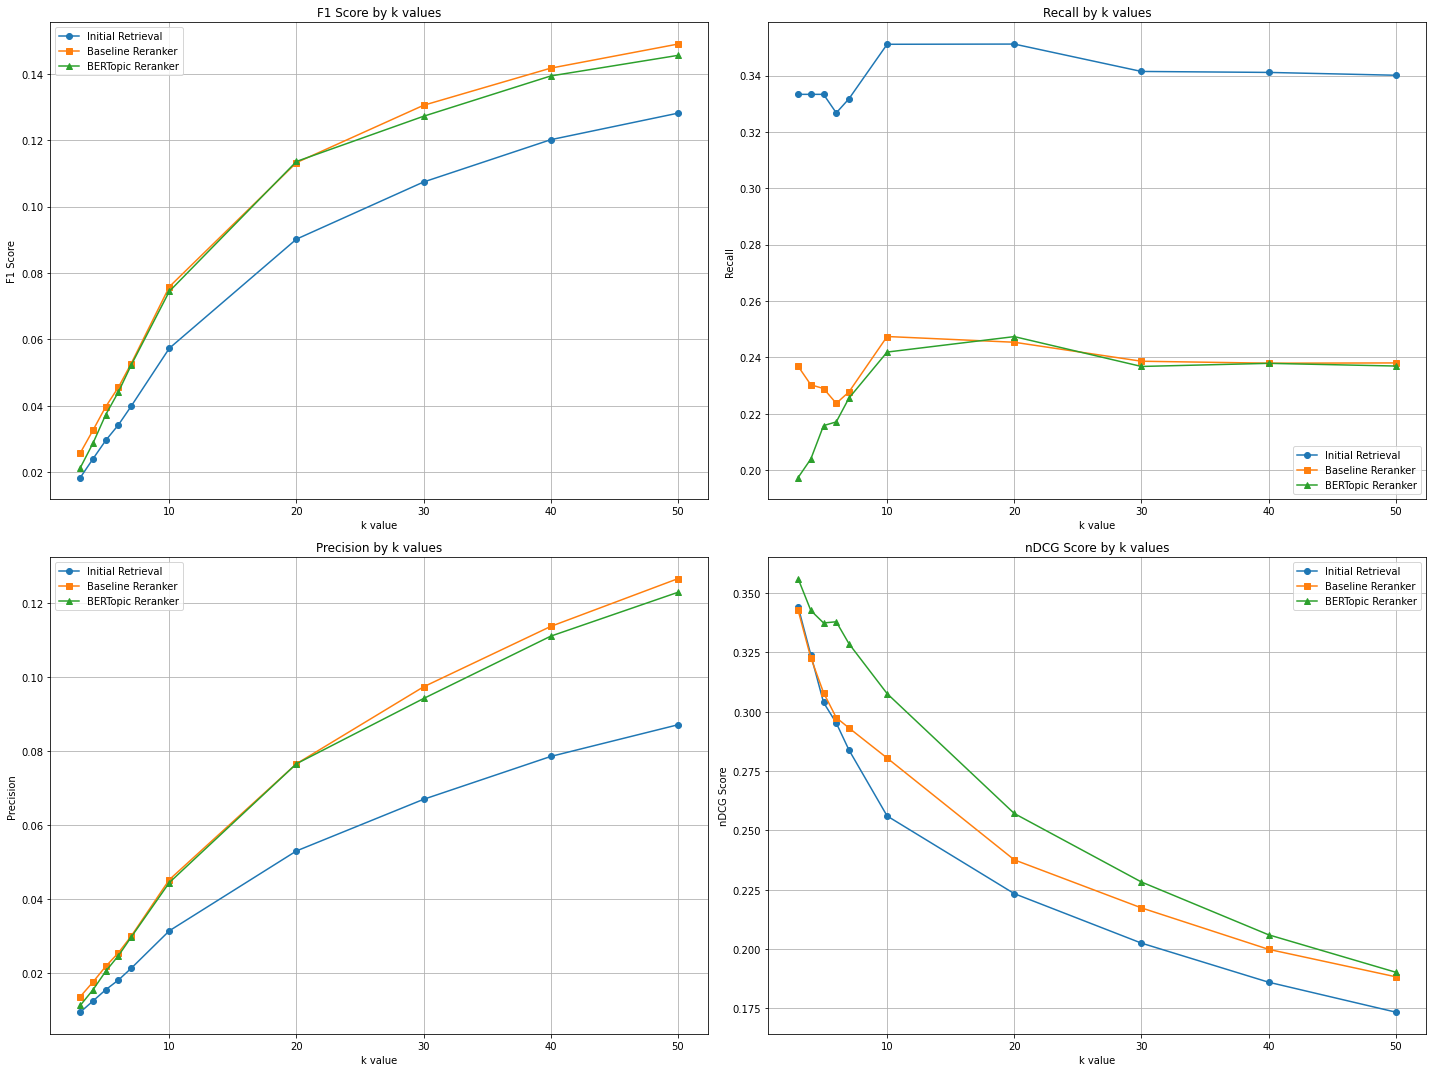

In [130]:
# Creating a subplot with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Plotting F1 Score
axs[0, 0].plot(k_values, initial_retrieval_results_f_1, marker='o', label='Initial Retrieval')
axs[0, 0].plot(k_values, baseline_reranker_results_f_1, marker='s', label='Baseline Reranker')
axs[0, 0].plot(k_values, bertopic_reranker_results_f_1, marker='^', label='BERTopic Reranker')
axs[0, 0].set_title('F1 Score by k values')
axs[0, 0].set_xlabel('k value')
axs[0, 0].set_ylabel('F1 Score')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plotting Recall
axs[0, 1].plot(k_values, initial_retrieval_results_recall, marker='o', label='Initial Retrieval')
axs[0, 1].plot(k_values, baseline_reranker_results_recall, marker='s', label='Baseline Reranker')
axs[0, 1].plot(k_values, bertopic_reranker_results_recall, marker='^', label='BERTopic Reranker')
axs[0, 1].set_title('Recall by k values')
axs[0, 1].set_xlabel('k value')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plotting Precision
axs[1, 0].plot(k_values, initial_retrieval_results_precision, marker='o', label='Initial Retrieval')
axs[1, 0].plot(k_values, baseline_reranker_results_precision, marker='s', label='Baseline Reranker')
axs[1, 0].plot(k_values, bertopic_reranker_results_precision, marker='^', label='BERTopic Reranker')
axs[1, 0].set_title('Precision by k values')
axs[1, 0].set_xlabel('k value')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plotting nDCG Score
axs[1, 1].plot(k_values, initial_retrieval_results_nDCG, marker='o', label='Initial Retrieval')
axs[1, 1].plot(k_values, baseline_reranker_results_nDCG, marker='s', label='Baseline Reranker')
axs[1, 1].plot(k_values, bertopic_reranker_results_nDCG, marker='^', label='BERTopic Reranker')
axs[1, 1].set_title('nDCG Score by k values')
axs[1, 1].set_xlabel('k value')
axs[1, 1].set_ylabel('nDCG Score')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjusting layout and displaying the plots
plt.tight_layout()
plt.show()

<h2> Sources: </h2>

* https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/
* https://www.kaggle.com/code/namansood/document-ranking-ir-system-word2vec-embeddings
* https://pypi.org/project/rank-bm25/

In [124]:
scores_lam = dict()
for lam_value in lam_values:
    bertopic_reranker_lam_scores = dict()
    for k in k_values:
        scores = evaluate(results_for_different_lams[lam_value], k)
        bertopic_reranker_lam_scores[k] = scores
    scores_lam[lam_value] = bertopic_reranker_lam_scores

In [125]:
scores_lam

{1.2: {3: {'f_1': 0.02137001771910353,
   'precision': 0.011315789473684215,
   'recall': 0.19736842105263155,
   'nDCG': 0.3567336087776632},
  4: {'f_1': 0.029268432519206498,
   'precision': 0.015789473684210534,
   'recall': 0.20723684210526316,
   'nDCG': 0.3387887500965494},
  5: {'f_1': 0.03783657003471244,
   'precision': 0.020789473684210538,
   'recall': 0.21842105263157896,
   'nDCG': 0.3254128326590611},
  6: {'f_1': 0.04468892820286009,
   'precision': 0.025000000000000015,
   'recall': 0.21929824561403505,
   'nDCG': 0.3158658688374358},
  7: {'f_1': 0.05273536007200668,
   'precision': 0.030000000000000016,
   'recall': 0.22744360902255642,
   'nDCG': 0.308625281389308},
  10: {'f_1': 0.07406262545006927,
   'precision': 0.0442105263157895,
   'recall': 0.24057017543859646,
   'nDCG': 0.28300583381381733},
  20: {'f_1': 0.1132536014591653,
   'precision': 0.07631578947368418,
   'recall': 0.24656228274649325,
   'nDCG': 0.24020967725033257},
  30: {'f_1': 0.1262853976060

In [95]:
lam_2_f1 = []
#lam_4_f1 = []
#lam_5_f1 = []
lam_1_2_f1 = []
lam_1_5_f1 = []
lam_2_5_f1 = []
lam_3_f1 = []
#lam_10_f1 = []

lam_2_nDCG = []
#lam_4_nDCG = []
#lam_5_nDCG = []
lam_1_2_nDCG = []
lam_1_5_nDCG = []
lam_2_5_nDCG = []
lam_3_nDCG = []
#lam_10_nDCG = []

for k in k_values:
    lam_2_f1.append(scores_lam[2][k]['f_1'])
 #   lam_4_f1.append(scores_lam[4][k]['f_1'])
 #   lam_5_f1.append(scores_lam[5][k]['f_1'])
    lam_1_2_f1.append(scores_lam[1.2][k]['f_1'])
    lam_1_5_f1.append(scores_lam[1.5][k]['f_1'])
    lam_2_5_f1.append(scores_lam[2.5][k]['f_1'])
    lam_3_f1.append(scores_lam[3][k]['f_1'])
 #   lam_10_f1.append(scores_lam[10][k]['f_1'])
    
    lam_2_nDCG.append(scores_lam[2][k]['nDCG'])
 #   lam_4_nDCG.append(scores_lam[4][k]['nDCG'])
 #   lam_5_nDCG.append(scores_lam[5][k]['nDCG'])
    lam_1_2_nDCG.append(scores_lam[1.2][k]['nDCG'])
    lam_1_5_nDCG.append(scores_lam[1.5][k]['nDCG'])
    lam_2_5_nDCG.append(scores_lam[2.5][k]['nDCG'])
    lam_3_nDCG.append(scores_lam[3][k]['nDCG'])
 #   lam_10_nDCG.append(scores_lam[10][k]['nDCG'])

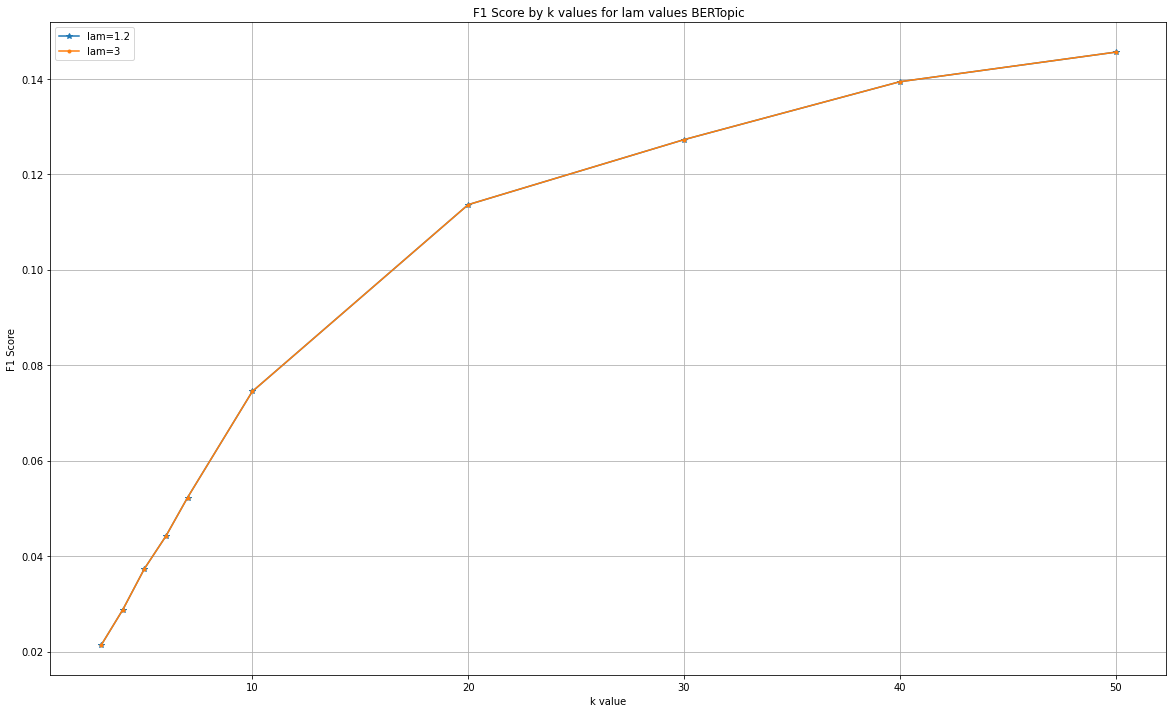

In [102]:
plt.figure(figsize=(20, 12))
#plt.plot(k_values, lam_2_f1, marker='o', label='lam=2')
#plt.plot(k_values, lam_4_f1, marker='s', label='lam=4')
#plt.plot(k_values, lam_5_f1, marker='^', label='lam=5')
plt.plot(k_values, lam_1_2_f1, marker='*', label='lam=1.2')
#plt.plot(k_values, lam_1_5_f1, marker='D', label='lam=1.5')
#plt.plot(k_values, lam_2_5_f1, marker='h', label='lam=2.5')
plt.plot(k_values, lam_3_f1, marker='.', label='lam=3')
#plt.plot(k_values, lam_10_f1, marker='x', label='lam=5')


plt.title('F1 Score by k values for lam values BERTopic')
plt.xlabel('k value')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

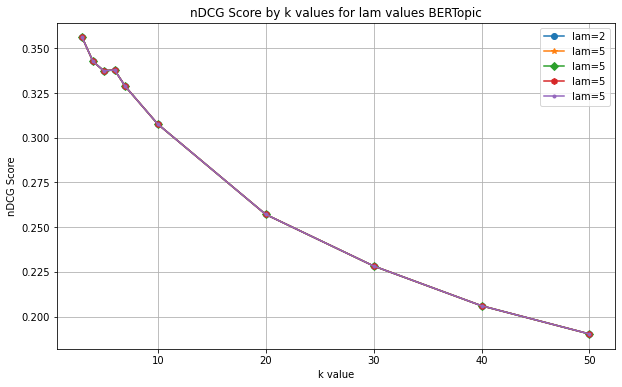

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, lam_2_nDCG, marker='o', label='lam=2')
#plt.plot(k_values, lam_4_nDCG, marker='s', label='lam=4')
#plt.plot(k_values, lam_5_nDCG, marker='^', label='lam=5')
plt.plot(k_values, lam_1_2_nDCG, marker='*', label='lam=5')
plt.plot(k_values, lam_1_5_nDCG, marker='D', label='lam=5')
plt.plot(k_values, lam_2_5_nDCG, marker='h', label='lam=5')
plt.plot(k_values, lam_3_nDCG, marker='.', label='lam=5')
#plt.plot(k_values, lam_10_nDCG, marker='x', label='lam=5')

plt.title('nDCG Score by k values for lam values BERTopic')
plt.xlabel('k value')
plt.ylabel('nDCG Score')
plt.legend()
plt.grid(True)
plt.show()